In [9]:
#load RASP: 
from rasp import RASP
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from esda import Moran
from libpysal.weights import KNN
from scipy.sparse import csr_matrix, issparse


In [4]:
#set the parameters 

seed = 2024

#for DLPFC: 
kNN_threshold = 6
beta = 2
num_pcs = 20
n_neighbors = 10
n_clusters = 7
cluster_algorithm = 'mclust'
ground_truth = 'ground_truth'
platform = 'visium'

In [5]:
# Replace with path to dataset on your machine 
adata = sc.read_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/mouse_MERFISH_data/data/DLPFC/processed/SCT3.h5ad")

In [6]:
#Preprocessing
#Note, the above dataset is already processed in R with the SCTransform algorithm. 
# Can use the count matrix directly now.

# Run the PCA 
if issparse(adata.X):
    data = adata.X.toarray()
else:
    data = adata.X
pca = PCA(n_components=num_pcs, svd_solver='randomized', random_state=seed)
pca_data = pca.fit_transform(data)

In [10]:
#construct the sparse distance matrix and turn into a weights matrix 
weights = RASP.build_weights_matrix(adata, n_neighbors=kNN_threshold, beta = beta, platform = platform)

#spatially smooth the pca_data 
smoothed_pca = weights @ csr_matrix(pca_data)    
# Convert to dense array if needed
smoothed_pca = smoothed_pca.toarray()

In [12]:
#assign back to the adata object and cluster! 
adata.obsm['X_pca_smoothed'] = smoothed_pca
sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_pca_smoothed')

In [13]:
#cluster
adata = RASP.clustering(adata, n_clusters=n_clusters, n_neighbors = n_neighbors,key='X_pca_smoothed', method=cluster_algorithm)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [14]:
#prepare object for plotting and print ARI 
coords = adata.obsm['spatial']
ground_truth_labels = adata.obs[ground_truth].astype(str)
labels = adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
ari = adjusted_rand_score(ground_truth_labels, labels)
CHAOS = RASP.CHAOS(labels, coords)

print(f"ARI: {ari}")
print(f"CHAOS: {CHAOS}")

#calculate Moran's I: 
w = KNN(coords, k=10)
unique_labels, labels_numeric = np.unique(labels, return_inverse=True)
moran = Moran(labels_numeric, w).I
print(f"Moran's I: {moran}")

ARI: 0.611713533584195
CHAOS: 0.06082358388224196
Moran's I: 0.7157181854829612


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


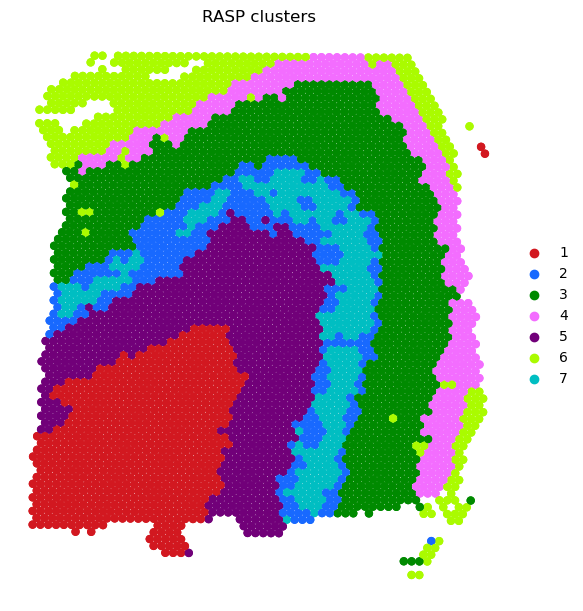

In [15]:
sq.pl.spatial_scatter(adata,
    color=[f'RASP_{cluster_algorithm}_clusters'],
    frameon=False,
    shape=None,
    figsize = (6,6),
    ncols = 2,
    size = 100,
    use_raw = False,title = "RASP clusters")

In [16]:
#now for the reconstruction code (reconstruct single stage RASP only):

#to reconstruct a specific gene signature from the spatially smoothed reduced rank dims computed above

visium_gene_example = 'TMSB10'
adata = RASP.reconstruct_gene(adata, 
                         smoothed_pca, 
                         pca.components_,
                         gene_name=visium_gene_example, 
                         quantile_prob=0.001,
                         scale = False,
                         threshold_method = 'ALRA',
                         rank_k = 20)

Threshold (absolute value for ALRA method): 1.8239434551338003
Number of cells below the threshold: 3510
Number of cells below zero: 1995
Number of cells restored to original values:1461
Number of cells that where negative: 473


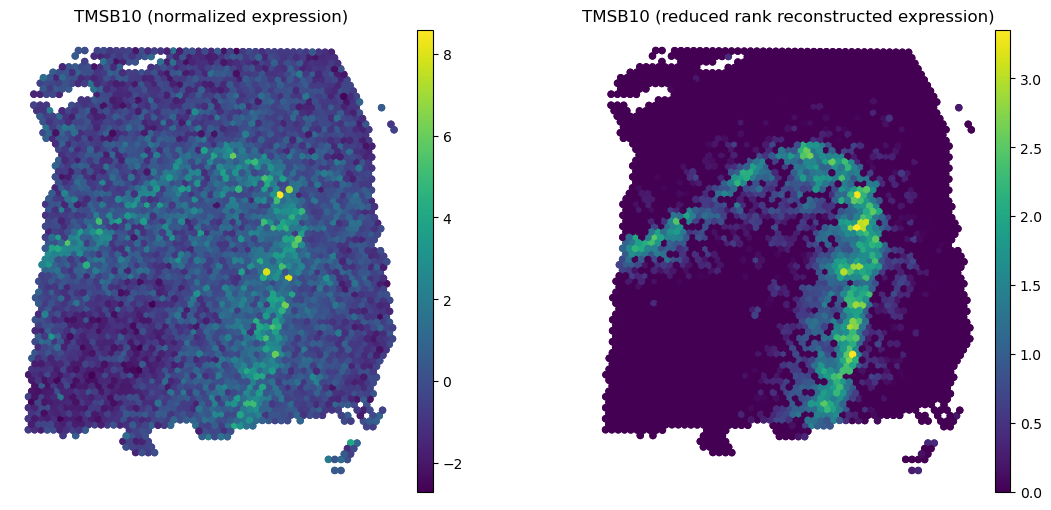

In [17]:
sq.pl.spatial_scatter(
    adata,
    color=[f'{visium_gene_example}',f'restored_{visium_gene_example}'],
    frameon=False,
    shape=None,
    figsize = (6,6),
    ncols = 2,
    size = 75,
    use_raw = False, 
    title = [f'{visium_gene_example} (normalized expression)',
             f'{visium_gene_example} (reduced rank reconstructed expression)']
    
)

In [30]:
import igraph
print(igraph.__version__)

0.11.5
